##  Piza Nava Vladimir - 111-494


## Laboratorio 2 

## Link al repositorio: https://github.com/vladi-13/Laboratorios/blob/main/Laboratorio2.ipynb

## Link al dataset: https://www.kaggle.com/datasets/vladi13/dataset-flores-piza-nava-vladimir

### Resumen de pasos:
1. **Importaciones**: Se importan módulos de PyTorch, transformaciones de imágenes y herramientas para manejo de datos.
2. **Configuración de DirectML**: Se configura DirectML como dispositivo para ejecutar operaciones en la GPU de AMD, si está disponible.
3. **Impresión de dispositivo**: Se imprime el dispositivo que se está utilizando (DirectML).


In [48]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import time
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch_directml  # DirectML para GPUs AMD

# Configurar DirectML
device = torch_directml.device()
print(f"Usando DirectML en: {device}")

Usando DirectML en: privateuseone:0


Este código prepara un conjunto de datos de imágenes de flores para entrenamiento y validación de un modelo de aprendizaje profundo:

1. **Transformaciones de imagen**: Redimensiona las imágenes a 64x64 píxeles, las convierte en tensores y las normaliza con valores estándar de ImageNet.
2. **Carga de CSV**: Carga un archivo CSV con rutas y etiquetas de las imágenes.
3. **Mapeo de etiquetas**: Convierte las etiquetas de texto a números.
4. **División del dataset**: Divide el conjunto de datos en entrenamiento (80%) y validación (20%).
5. **Dataset personalizado**: Crea una clase `FlowerDataset` que maneja las imágenes y sus etiquetas, aplicando las transformaciones.
6. **DataLoader**: Carga los datos en lotes para entrenamiento y validación.

Finalmente, imprime el mapeo de etiquetas y el tamaño de los conjuntos de entrenamiento y validación.

In [49]:
# Transformaciones de imagen
transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Cargar CSV con rutas y etiquetas
df = pd.read_csv('dataset_flores.csv')

# Convertir etiquetas a números
label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label'] = df['label'].map(label_mapping)

# Dividir en entrenamiento y validación (80% - 20%)
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

class FlowerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label
    
# Cargar datasets
dataset = {
    'train': FlowerDataset(train_df, transform=transform),
    'val': FlowerDataset(val_df, transform=transform)
}

dataloader = {
    'train': DataLoader(dataset['train'], batch_size=256, shuffle=True, num_workers=0, pin_memory=True),
    'val': DataLoader(dataset['val'], batch_size=256, shuffle=False, num_workers=0, pin_memory=True)
}

#mostrar mapeo
print(label_mapping)

#mostrar tamaño de dataset
print(f"Tamaño del dataset de entrenamiento: {len(dataset['train'])}")
print(f"Tamaño del dataset de validación: {len(dataset['val'])}")

{'Astromelia': 0, 'Cartucho': 1, 'Lirio': 2, 'Obispo': 3, 'SanJuan': 4}
Tamaño del dataset de entrenamiento: 40000
Tamaño del dataset de validación: 10000


## Explicación General del Código

### `build_model`
Crea un modelo de **perceptrón multicapa (MLP)** en PyTorch con:
1. **Capa de entrada**: Aplana la imagen para que pase a las capas lineales.
2. **Capas ocultas**: Dos capas lineales con activación ReLU, normalización y dropout (para prevenir sobreajuste).
3. **Capa de salida**: Predice la clase con un número de unidades igual a las clases del dataset.
4. El modelo se transfiere al dispositivo con tipo de dato `float32`.

### `EarlyStopping`
La clase **early stopping** detiene el entrenamiento si la pérdida de validación no mejora después de un número de épocas (definido por `patience`), ayudando a prevenir sobreajuste y ahorrar tiempo de cómputo.

### Resumen:
- **MLP**: Red neuronal con capas lineales y regularización.
- **Early Stopping**: Detiene el entrenamiento si no hay mejora en la pérdida.

In [ ]:
def build_model(input_size=64*64*3, hidden_size=128, output_size=len(label_mapping), dropout=0.5):
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_size, hidden_size, dtype=torch.float32),
        nn.BatchNorm1d(hidden_size, dtype=torch.float32),
        nn.ReLU(),
        nn.Dropout(dropout), # Apagar el 50% de las neuronas

        nn.Linear(hidden_size, 50, dtype=torch.float32),
        nn.BatchNorm1d(50, dtype=torch.float32),
        nn.ReLU(),
        nn.Dropout(dropout),

        nn.Linear(50, output_size, dtype=torch.float32)
    ).to(device, dtype=torch.float32)

class EarlyStopping:
    def __init__(self, patience=10, delta=0, model_path="best_model_lab2.pth"):
        self.patience = patience
        self.delta = delta
        self.best_loss = np.inf
        self.counter = 0
        self.stop_training = False
        self.model_path = model_path

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.model_path)
            print(f"  🔥 Nuevo mejor modelo guardado en {self.model_path}!")
        else:
            self.counter += 1
            print(f"  ⏳ Early Stopping Counter: {self.counter}/{self.patience}")

        if self.counter >= self.patience:
            print("\n🚨 Deteniendo entrenamiento por Early Stopping 🚨")
            self.stop_training = True

Este código entrena un modelo utilizando **Early Stopping** y **Checkpointing**:

1. **Entrenamiento**:
   - Utiliza `tqdm` para mostrar el progreso del entrenamiento.
   - Para cada época, calcula la pérdida (`loss`) y la precisión del modelo en los datos de entrenamiento.
   - Optimiza el modelo utilizando el optimizador Adam.

2. **Evaluación en validación**:
   - Al final de cada época, evalúa el modelo en los datos de validación, calcula la pérdida y la precisión.
   
3. **Early Stopping**:
   - Si la pérdida de validación no mejora después de un número de épocas definidas por `patience`, el entrenamiento se detiene.

4. **Checkpointing**:
   - Guarda un modelo cada cierto número de épocas (`checkpoint_interval`), permitiendo la reanudación del entrenamiento o evaluación más tarde.

5. **Guardar el mejor modelo**:
   - Guarda el modelo con la mejor precisión de validación como `best_model_lab2.pth`.

Este código es útil para entrenar modelos durante un número de épocas sin sobreajustar, guardando el mejor modelo y creando puntos de control para reanudar el entrenamiento.

In [ ]:
from tqdm import tqdm

def train_model_with_early_stopping(model, dataloader, epochs=1000, checkpoint_interval=20, patience=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) 

    early_stopping = EarlyStopping(patience=patience, model_path="best_model_lab2.pth")
    best_val_loss = np.inf
    best_model_wts = model.state_dict()
    best_val_acc = 0.0

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss, correct, total = 0, 0, 0
        start_time = time.time()

        with tqdm(total=len(dataloader['train']), desc=f"Epoch {epoch}/{epochs} | Training", ncols=100) as pbar:
            for images, labels in dataloader['train']:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad() #inicializar gradientes a cero
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                correct += (outputs.argmax(1) == labels).sum().item()
                total += labels.size(0)
                pbar.set_postfix(loss=loss.item(), accuracy=correct / total)
                pbar.update(1)

        train_acc = correct / total
        elapsed_time = time.time() - start_time
        avg_train_loss = total_loss / len(dataloader['train'])
        print(f"Epoch {epoch}/{epochs} | Accuracy={train_acc:.3f}, Loss={avg_train_loss:.3f}")

        # Evaluación en validación
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in dataloader['val']:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / len(dataloader['val'])
        val_acc = val_correct / val_total
        print(f"🔵 Validation Accuracy: {val_acc:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # Guardar el mejor modelo según la precisión
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(model.state_dict(), "best_model_lab2.pth")
            print(f"🌟 Mejor modelo guardado como best_model_lab2.pth con Val Acc: {best_val_acc:.4f}")

        # Guardar Checkpoints
        if epoch % checkpoint_interval == 0:
            checkpoint_path = f"checkpoints/mlp_epoch_{epoch}.pth"
            torch.save(model.state_dict(), checkpoint_path)
            print(f"✅ Checkpoint guardado en: {checkpoint_path}")

        # Early Stopping
        early_stopping(avg_val_loss, model)
        if early_stopping.stop_training:
            break

    # Cargar el mejor modelo
    model.load_state_dict(best_model_wts)
    return model

1. **Construcción del modelo**:
   Llama a la función `build_model()` para crear una red neuronal personalizada con una estructura de capas totalmente conectadas.

2. **Entrenamiento con Early Stopping**:
   Llama a la función `train_model_with_early_stopping()` para entrenar el modelo. Esta función entrena el modelo durante un número de épocas, guarda los mejores modelos basados en la precisión de validación, y aplica "early stopping" para detener el entrenamiento si el rendimiento de validación no mejora después de un número de épocas (controlado por el parámetro `patience`). También guarda puntos de control del modelo en intervalos definidos.

En resumen, el código construye un modelo de red neuronal, lo entrena y gestiona el proceso con early stopping y guardado de modelos durante el entrenamiento.

In [52]:
model = build_model()
trained_model = train_model_with_early_stopping(model, dataloader, epochs=1000, checkpoint_interval=20, patience=10)

Epoch 1/1000 | Training:   0%|                                              | 0/157 [00:00<?, ?it/s]c:\Users\vladi\OneDrive\Documentos\Universidad\Sexto Semestre\SIS421\Laboratorios\entorno\lib\site-packages\torch\optim\adam.py:534: UserWarning: The operator 'aten::lerp.Scalar_out' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  torch._foreach_lerp_(device_exp_avgs, device_grads, 1 - beta1)
Epoch 1/1000 | Training: 100%|████████| 157/157 [03:34<00:00,  1.37s/it, accuracy=0.727, loss=0.591]


Epoch 1/1000 | Accuracy=0.727, Loss=0.802
🔵 Validation Accuracy: 0.8844, Validation Loss: 0.3688
🌟 Mejor modelo guardado como best_model_lab2.pth con Val Acc: 0.8844
  🔥 Nuevo mejor modelo guardado en best_model_lab2.pth!


Epoch 2/1000 | Training: 100%|████████| 157/157 [03:07<00:00,  1.19s/it, accuracy=0.852, loss=0.403]


Epoch 2/1000 | Accuracy=0.852, Loss=0.439
🔵 Validation Accuracy: 0.9266, Validation Loss: 0.2297
🌟 Mejor modelo guardado como best_model_lab2.pth con Val Acc: 0.9266
  🔥 Nuevo mejor modelo guardado en best_model_lab2.pth!


Epoch 3/1000 | Training: 100%|█████████| 157/157 [03:09<00:00,  1.21s/it, accuracy=0.88, loss=0.233]


Epoch 3/1000 | Accuracy=0.880, Loss=0.352
🔵 Validation Accuracy: 0.9342, Validation Loss: 0.1969
🌟 Mejor modelo guardado como best_model_lab2.pth con Val Acc: 0.9342
  🔥 Nuevo mejor modelo guardado en best_model_lab2.pth!


Epoch 4/1000 | Training: 100%|██████████| 157/157 [03:13<00:00,  1.23s/it, accuracy=0.9, loss=0.211]


Epoch 4/1000 | Accuracy=0.900, Loss=0.301
🔵 Validation Accuracy: 0.9496, Validation Loss: 0.1601
🌟 Mejor modelo guardado como best_model_lab2.pth con Val Acc: 0.9496
  🔥 Nuevo mejor modelo guardado en best_model_lab2.pth!


Epoch 5/1000 | Training: 100%|█████████| 157/157 [03:06<00:00,  1.19s/it, accuracy=0.908, loss=0.27]


Epoch 5/1000 | Accuracy=0.908, Loss=0.276
🔵 Validation Accuracy: 0.9519, Validation Loss: 0.1469
🌟 Mejor modelo guardado como best_model_lab2.pth con Val Acc: 0.9519
  🔥 Nuevo mejor modelo guardado en best_model_lab2.pth!


Epoch 6/1000 | Training: 100%|████████| 157/157 [03:14<00:00,  1.24s/it, accuracy=0.917, loss=0.256]


Epoch 6/1000 | Accuracy=0.917, Loss=0.250
🔵 Validation Accuracy: 0.9549, Validation Loss: 0.1373
🌟 Mejor modelo guardado como best_model_lab2.pth con Val Acc: 0.9549
  🔥 Nuevo mejor modelo guardado en best_model_lab2.pth!


Epoch 7/1000 | Training: 100%|████████| 157/157 [03:11<00:00,  1.22s/it, accuracy=0.922, loss=0.117]


Epoch 7/1000 | Accuracy=0.922, Loss=0.236
🔵 Validation Accuracy: 0.9611, Validation Loss: 0.1215
🌟 Mejor modelo guardado como best_model_lab2.pth con Val Acc: 0.9611
  🔥 Nuevo mejor modelo guardado en best_model_lab2.pth!


Epoch 8/1000 | Training: 100%|████████| 157/157 [03:31<00:00,  1.34s/it, accuracy=0.927, loss=0.229]


Epoch 8/1000 | Accuracy=0.927, Loss=0.223
🔵 Validation Accuracy: 0.9633, Validation Loss: 0.1166
🌟 Mejor modelo guardado como best_model_lab2.pth con Val Acc: 0.9633
  🔥 Nuevo mejor modelo guardado en best_model_lab2.pth!


Epoch 9/1000 | Training: 100%|█████████| 157/157 [03:18<00:00,  1.27s/it, accuracy=0.93, loss=0.202]


Epoch 9/1000 | Accuracy=0.930, Loss=0.214
🔵 Validation Accuracy: 0.9610, Validation Loss: 0.1193
  ⏳ Early Stopping Counter: 1/10


Epoch 10/1000 | Training: 100%|███████| 157/157 [03:19<00:00,  1.27s/it, accuracy=0.932, loss=0.408]


Epoch 10/1000 | Accuracy=0.932, Loss=0.210
🔵 Validation Accuracy: 0.9632, Validation Loss: 0.1130
  🔥 Nuevo mejor modelo guardado en best_model_lab2.pth!


Epoch 11/1000 | Training: 100%|███████| 157/157 [03:21<00:00,  1.28s/it, accuracy=0.933, loss=0.219]


Epoch 11/1000 | Accuracy=0.933, Loss=0.206
🔵 Validation Accuracy: 0.9661, Validation Loss: 0.1073
🌟 Mejor modelo guardado como best_model_lab2.pth con Val Acc: 0.9661
  🔥 Nuevo mejor modelo guardado en best_model_lab2.pth!


Epoch 12/1000 | Training: 100%|████████| 157/157 [05:13<00:00,  1.99s/it, accuracy=0.935, loss=0.16]


Epoch 12/1000 | Accuracy=0.935, Loss=0.195
🔵 Validation Accuracy: 0.9669, Validation Loss: 0.1053
🌟 Mejor modelo guardado como best_model_lab2.pth con Val Acc: 0.9669
  🔥 Nuevo mejor modelo guardado en best_model_lab2.pth!


Epoch 13/1000 | Training: 100%|███████| 157/157 [05:11<00:00,  1.99s/it, accuracy=0.939, loss=0.334]


Epoch 13/1000 | Accuracy=0.939, Loss=0.188
🔵 Validation Accuracy: 0.9662, Validation Loss: 0.1075
  ⏳ Early Stopping Counter: 1/10


Epoch 14/1000 | Training: 100%|██████| 157/157 [03:20<00:00,  1.28s/it, accuracy=0.941, loss=0.0898]


Epoch 14/1000 | Accuracy=0.941, Loss=0.180
🔵 Validation Accuracy: 0.9661, Validation Loss: 0.1037
  🔥 Nuevo mejor modelo guardado en best_model_lab2.pth!


Epoch 15/1000 | Training: 100%|███████| 157/157 [03:18<00:00,  1.27s/it, accuracy=0.942, loss=0.211]


Epoch 15/1000 | Accuracy=0.942, Loss=0.179
🔵 Validation Accuracy: 0.9694, Validation Loss: 0.0976
🌟 Mejor modelo guardado como best_model_lab2.pth con Val Acc: 0.9694
  🔥 Nuevo mejor modelo guardado en best_model_lab2.pth!


Epoch 16/1000 | Training: 100%|███████| 157/157 [03:21<00:00,  1.28s/it, accuracy=0.943, loss=0.182]


Epoch 16/1000 | Accuracy=0.943, Loss=0.173
🔵 Validation Accuracy: 0.9687, Validation Loss: 0.0987
  ⏳ Early Stopping Counter: 1/10


Epoch 17/1000 | Training: 100%|███████| 157/157 [03:16<00:00,  1.25s/it, accuracy=0.943, loss=0.211]


Epoch 17/1000 | Accuracy=0.943, Loss=0.175
🔵 Validation Accuracy: 0.9705, Validation Loss: 0.0920
🌟 Mejor modelo guardado como best_model_lab2.pth con Val Acc: 0.9705
  🔥 Nuevo mejor modelo guardado en best_model_lab2.pth!


Epoch 18/1000 | Training: 100%|███████| 157/157 [03:11<00:00,  1.22s/it, accuracy=0.943, loss=0.404]


Epoch 18/1000 | Accuracy=0.943, Loss=0.175
🔵 Validation Accuracy: 0.9697, Validation Loss: 0.0961
  ⏳ Early Stopping Counter: 1/10


Epoch 19/1000 | Training: 100%|████████| 157/157 [03:17<00:00,  1.26s/it, accuracy=0.944, loss=0.25]


Epoch 19/1000 | Accuracy=0.944, Loss=0.172
🔵 Validation Accuracy: 0.9729, Validation Loss: 0.0853
🌟 Mejor modelo guardado como best_model_lab2.pth con Val Acc: 0.9729
  🔥 Nuevo mejor modelo guardado en best_model_lab2.pth!


Epoch 20/1000 | Training: 100%|███████| 157/157 [03:17<00:00,  1.26s/it, accuracy=0.947, loss=0.209]


Epoch 20/1000 | Accuracy=0.947, Loss=0.164
🔵 Validation Accuracy: 0.9719, Validation Loss: 0.0869
✅ Checkpoint guardado en: checkpoints/mlp_epoch_20.pth
  ⏳ Early Stopping Counter: 1/10


Epoch 21/1000 | Training: 100%|█████████| 157/157 [03:21<00:00,  1.29s/it, accuracy=0.949, loss=0.3]


Epoch 21/1000 | Accuracy=0.949, Loss=0.159
🔵 Validation Accuracy: 0.9697, Validation Loss: 0.0930
  ⏳ Early Stopping Counter: 2/10


Epoch 22/1000 | Training: 100%|███████| 157/157 [03:28<00:00,  1.33s/it, accuracy=0.949, loss=0.129]


Epoch 22/1000 | Accuracy=0.949, Loss=0.157
🔵 Validation Accuracy: 0.9700, Validation Loss: 0.0976
  ⏳ Early Stopping Counter: 3/10


Epoch 23/1000 | Training: 100%|██████| 157/157 [03:22<00:00,  1.29s/it, accuracy=0.949, loss=0.0934]


Epoch 23/1000 | Accuracy=0.949, Loss=0.155
🔵 Validation Accuracy: 0.9716, Validation Loss: 0.0895
  ⏳ Early Stopping Counter: 4/10


Epoch 24/1000 | Training: 100%|██████| 157/157 [03:18<00:00,  1.26s/it, accuracy=0.951, loss=0.0847]


Epoch 24/1000 | Accuracy=0.951, Loss=0.152
🔵 Validation Accuracy: 0.9708, Validation Loss: 0.0920
  ⏳ Early Stopping Counter: 5/10


Epoch 25/1000 | Training: 100%|███████| 157/157 [03:20<00:00,  1.28s/it, accuracy=0.946, loss=0.213]


Epoch 25/1000 | Accuracy=0.946, Loss=0.161
🔵 Validation Accuracy: 0.9720, Validation Loss: 0.0906
  ⏳ Early Stopping Counter: 6/10


Epoch 26/1000 | Training: 100%|███████| 157/157 [03:18<00:00,  1.26s/it, accuracy=0.952, loss=0.213]


Epoch 26/1000 | Accuracy=0.952, Loss=0.151
🔵 Validation Accuracy: 0.9711, Validation Loss: 0.0878
  ⏳ Early Stopping Counter: 7/10


Epoch 27/1000 | Training: 100%|████████| 157/157 [03:17<00:00,  1.26s/it, accuracy=0.95, loss=0.142]


Epoch 27/1000 | Accuracy=0.950, Loss=0.155
🔵 Validation Accuracy: 0.9724, Validation Loss: 0.0888
  ⏳ Early Stopping Counter: 8/10


Epoch 28/1000 | Training: 100%|███████| 157/157 [03:16<00:00,  1.25s/it, accuracy=0.949, loss=0.136]


Epoch 28/1000 | Accuracy=0.949, Loss=0.155
🔵 Validation Accuracy: 0.9695, Validation Loss: 0.0918
  ⏳ Early Stopping Counter: 9/10


Epoch 29/1000 | Training: 100%|████████| 157/157 [03:20<00:00,  1.27s/it, accuracy=0.95, loss=0.204]


Epoch 29/1000 | Accuracy=0.950, Loss=0.153
🔵 Validation Accuracy: 0.9732, Validation Loss: 0.0868
🌟 Mejor modelo guardado como best_model_lab2.pth con Val Acc: 0.9732
  ⏳ Early Stopping Counter: 10/10

🚨 Deteniendo entrenamiento por Early Stopping 🚨


Este código realiza lo siguiente:

1. **Carga el modelo**: Crea una instancia del modelo, carga los pesos entrenados desde `"best_model_lab2.pth"` y lo coloca en CPU.

2. **Exporta a TorchScript**: Convierte el modelo a una versión optimizada de PyTorch llamada TorchScript y la guarda en un archivo `.pt`.

3. **(Opcional) Exportar a ONNX**: El código comentado muestra cómo exportar el modelo a ONNX, un formato estándar para la interoperabilidad entre diferentes frameworks de deep learning.

En resumen, convierte el modelo a formatos listos para ser utilizados fuera de PyTorch.

In [53]:
import torch
import torch.onnx

# Crear una instancia del modelo y cargar los pesos
model = build_model()
model.load_state_dict(torch.load("best_model_lab2.pth", map_location=torch.device("cpu")))
model.to("cpu")  # Asegurar que el modelo esté en CPU
model.eval()

# Exportar a TorchScript
scripted_model = torch.jit.script(model)
scripted_model.save("mlp_model.pt")
print("✅ Modelo exportado a TorchScript: mlp_model.pt")

# Exportar a ONNX
# dummy_input = torch.randn(1, 3, 64, 64).to("cpu")  # Asegurar que el input esté en CPU
# torch.onnx.export(model, dummy_input, "mlp_model.onnx", export_params=True)
# print("✅ Modelo exportado a ONNX: mlp_model.onnx")

✅ Modelo exportado a TorchScript: mlp_model.pt


C:\Users\vladi\AppData\Local\Temp\ipykernel_2008\748554411.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_lab2.pth", map_lo

Este código realiza lo siguiente:

1. **Función `cargar_y_evaluar_modelo`**:
   - Carga los pesos del modelo desde un archivo `.pth`.
   - Establece el modelo en modo de evaluación (`eval()`), lo que desactiva el comportamiento de entrenamiento como el dropout.
   - Realiza la evaluación del modelo sobre el conjunto de validación, calculando la pérdida y la precisión:
     - Para cada batch, obtiene las imágenes y sus etiquetas, las pasa por el modelo, calcula la pérdida y predice las clases.
     - Suma la pérdida total y calcula la precisión comparando las predicciones con las etiquetas reales.

2. **Evaluación**:
   - Se carga el modelo previamente entrenado (`best_model_lab2.pth`), y se mueve a la GPU o CPU según el dispositivo.
   - Luego, se evalúa el modelo en el conjunto de validación usando la función `cargar_y_evaluar_modelo`, con el criterio de pérdida `CrossEntropyLoss`.
   
Finalmente, se imprime la precisión y la pérdida promedio del modelo en el conjunto de validación.

In [54]:
def cargar_y_evaluar_modelo(model, model_path, val_loader, criterion, device):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.long)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(val_loader)

    print(f'Precisión: {accuracy:.2f}% - Pérdida Promedio: {avg_loss:.4f}')
    return accuracy, avg_loss

# Cargar el modelo previamente entrenado
model = build_model()  # Asegúrate de usar la misma arquitectura que la que usaste para entrenar el modelo
model.load_state_dict(torch.load("best_model_lab2.pth", map_location=device))  # Cargar los pesos del mejor modelo
model.to(device)  # Mover el modelo al dispositivo adecuado (GPU o CPU)
model.eval()  # Establecer el modelo en modo de evaluación

# Definir el criterio de pérdida (usando CrossEntropyLoss en este caso)
criterion = nn.CrossEntropyLoss()

# Evaluar el modelo en el conjunto de validación
accuracy, avg_loss = cargar_y_evaluar_modelo(model, "best_model_lab2.pth", dataloader['val'], criterion, device)

C:\Users\vladi\AppData\Local\Temp\ipykernel_2008\3886177925.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_lab2.pth", map_

Precisión: 97.32% - Pérdida Promedio: 0.0868


Este código realiza las siguientes tareas:

1. **Cargar datos**: Lee un archivo CSV que contiene rutas de imágenes y sus respectivas etiquetas.
   
2. **Seleccionar imagen aleatoria**: Escoge una imagen aleatoria del CSV usando `pandas`.

3. **Transformación de la imagen**: Aplica transformaciones a la imagen, como redimensionarla a 64x64 píxeles, convertirla en un tensor y normalizarla para que sea compatible con el modelo.

4. **Predecir la clase**: Carga el modelo preentrenado, pasa la imagen a través de él y obtiene la clase predicha (la clase con la probabilidad más alta).

5. **Mostrar resultado**: Muestra la imagen con su predicción y la clase real en un gráfico usando `matplotlib`. Si no se encuentran imágenes en el CSV, imprime un mensaje indicando eso.

Este proceso es útil para validar visualmente el rendimiento del modelo en ejemplos reales.

C:\Users\vladi\AppData\Local\Temp\ipykernel_2008\266467153.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_lab2.pth", map_l

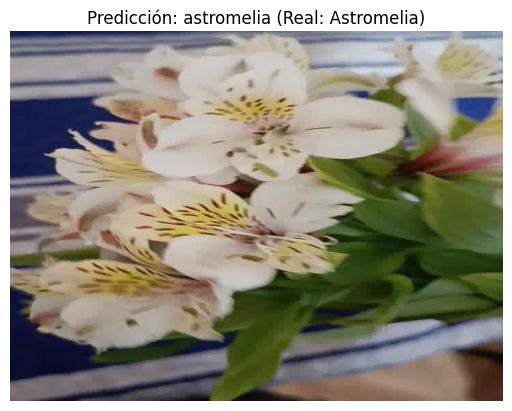

In [89]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch

# Lista de clases
class_names = ["astromelia", "cartucho", "lirio", "obispo", "sanjuan"]

def elegir_imagen_aleatoria(csv_path="dataset_flores.csv"):
    """Selecciona aleatoriamente una imagen desde un CSV con rutas y clases."""
    df = pd.read_csv(csv_path)
    
    if df.empty:
        return None, None
    
    fila = df.sample(n=1).iloc[0]  # Seleccionar una fila aleatoria
    return fila["image_path"], fila["label"]

# Definir la transformación para la imagen
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Redimensionar a 64x64
    transforms.ToTensor(),        # Convertir a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar
])

def predecir_imagen(model, image_path, class_names, device):
    """Carga una imagen, la pasa por el modelo y devuelve la predicción."""
    image = Image.open(image_path).convert("RGB")  # Cargar la imagen
    image_tensor = transform(image).unsqueeze(0).to(device)  # Aplicar transformaciones

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)  # Obtener la clase con mayor probabilidad

    prediccion = class_names[predicted.item()]  # Convertir índice a nombre de clase
    return image, prediccion

# Cargar modelo guardado
model = build_model(input_size=64*64*3, hidden_size=128, output_size=len(class_names), dropout=0.5).to(device)
model.load_state_dict(torch.load("best_model_lab2.pth", map_location=device))
model.eval()

# Predecir una imagen aleatoria desde el CSV
image_path, clase_real = elegir_imagen_aleatoria()
if image_path:
    image, prediccion = predecir_imagen(model, image_path, class_names, device)

    # Mostrar la imagen con su predicción y clase real
    plt.imshow(image)
    plt.title(f'Predicción: {prediccion} (Real: {clase_real})')
    plt.axis('off')
    plt.show()
else:
    print("No se encontraron imágenes en el CSV.")